In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("/Users/sachshur/Desktop/Rice Classes/Spring 2025/COMP 449/HERC_Sp25/0_Datasets/1.7Master_Files/Individual Year Files_Take2/merged_2023.csv")

distprof = pd.read_csv("/Users/sachshur/Desktop/Rice Classes/Spring 2025/COMP 449/HERC_Sp25/0_Datasets/1.6Data2023/District/clean_data/distprof_2023_clean.csv")

print(df.isna().sum())

DISTRICT_id                                                    0
District 2022 Attendance: All Students Days Present            6
District 2022 Attendance: Two or More Races Days Present     356
District 2022 Attendance: Asian Days Present                 725
District 2022 Attendance: Pacific Islander Days Present     1032
                                                            ... 
TEA District Type                                              0
TEA Description                                                0
NCES District Type                                             0
NCES Description                                               0
Charter School (Y/N)                                           0
Length: 6553, dtype: int64


In [4]:
student_features = [
    'District 2023 Student Membership: White Percent',
    'District 2023 Student Membership: African American Percent',
    'District 2023 Student Membership: Hispanic Percent',
    'District 2023 Student Membership: American Indian Percent',
    'District 2023 Student Membership: Asian Percent',
    'District 2023 Student Membership: Pacific Islander Percent',
    'District 2023 Student Membership: Two or More Races Percent',
    'District 2023 Student Membership: Econ Disadv Percent',
    'District 2023 Student Membership: Non-Educationally Disadv Percent',
    'District 2023 Student Membership: At Risk Percent',
    'District 2023 Student Membership: EB/EL Percent'
]

staff_features = [
    'District 2023 Staff: Teacher No Degree Full Time Equiv Percent',
    'District 2023 Staff: Teacher BA Degree Full Time Equiv Percent',
    'District 2023 Staff: Teacher MS Degree Full Time Equiv Percent',
    'District 2023 Staff: Teacher PH Degree Full Time Equiv Percent',
    'District 2023 Staff: Teacher Beginning Full Time Equiv Percent',
    'District 2023 Staff: Teacher 1-5 Years Full Time Equiv Percent',
    'District 2023 Staff: Teacher 6-10 Years Full Time Equiv Percent',
    'District 2023 Staff: Teacher 11-20 Years Full Time Equiv Percent',
    'District 2023 Staff: Teacher 21-30 Years Full Time Equiv Percent',
    'District 2023 Staff: Teacher > 30 Years Full Time Equiv Percent',
    'District 2023 Staff: Teacher Regular Program Full Time Equiv Percent'
]

df = df[student_features + staff_features]
print(df)
print("=====================")
print(df.isna().sum())

      District 2023 Student Membership: White Percent  \
0                                                80.8   
1                                                79.3   
2                                                75.0   
3                                                77.0   
4                                                27.5   
...                                               ...   
1204                                             77.6   
1205                                             58.1   
1206                                              0.4   
1207                                              0.6   
1208                                              5.3   

      District 2023 Student Membership: African American Percent  \
0                                                   4.7            
1                                                   4.0            
2                                                   8.0            
3                                          

In [5]:
def calculate_missing_percentage(df):
    """
    Function to calculate the percentage of missing values in each column of a given dataset.
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
    
    Returns:
        pd.Series: A Series with column names as index and percentage of missing values as values.
    """
    missing_percentage = (df.isna().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0]  # Only keep columns with missing values
    
    return missing_percentage.sort_values(ascending=False)  # Sort in descending order
def drop_columns(df, threshold=50):
    """
    Function to drop columns with missing values exceeding a specified threshold
    and columns containing 'numerator' or 'denominator' in their names. These columsn are going to be fairly useless for analysis 
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
        threshold (float): The percentage threshold for dropping columns.
    
    Returns:
        pd.DataFrame: The dataframe with columns dropped.
    """
    print(f"Original Dataset Shape: {df.shape}")
    missing_percentage = calculate_missing_percentage(df)
    cols_to_drop = set(missing_percentage[missing_percentage >= threshold].index)
    
    # Drop columns containing 'numerator' or 'denominator' (case-insensitive)
    cols_to_drop.update([col for col in df.columns if 'numerator' in col.lower() or 'denominator' in col.lower()])
    
    resulting_df = df.drop(columns=cols_to_drop)
    print(f"Dropped Dataset Shape: {resulting_df.shape}")
    return resulting_df

df = drop_columns(df)
df.shape

Original Dataset Shape: (1209, 22)
Dropped Dataset Shape: (1209, 22)


(1209, 22)

In [6]:
def preprocess_data(df, feature_list):
    data = df[feature_list].copy()
    
    data = data.apply(pd.to_numeric, errors='coerce')
    
    data.fillna(df.median(), inplace=True)
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    return data, data_scaled

In [7]:
def find_optimal_k(data_scaled, max_k=10):
    wcss = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k+1), wcss, marker='o', linestyle='--', color='blue')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow Method for Optimal K")
    plt.show()

In [8]:
def apply_kmeans(data, data_scaled, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_scaled)
    
    data['Cluster'] = clusters
    
    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns[:-1])
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='Cluster', bins=num_clusters, color='blue', discrete=True)
    plt.xlabel("Cluster Label")
    plt.ylabel("Count of Districts")
    plt.title("Distribution of Districts Across Clusters")
    plt.show()
    
    return data, centroids

Processing Student Membership Clustering...



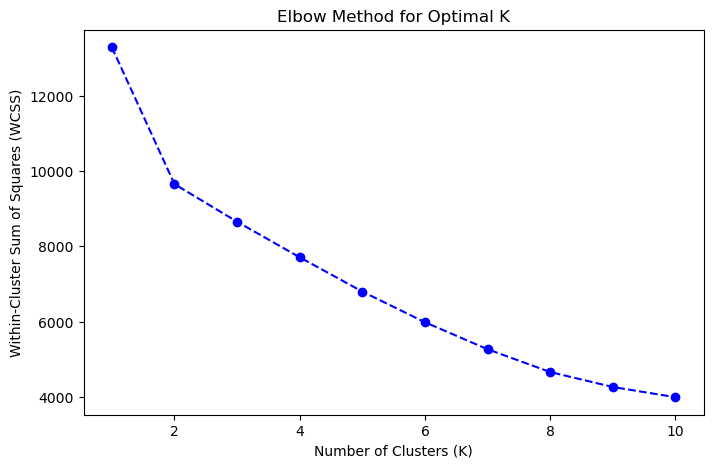

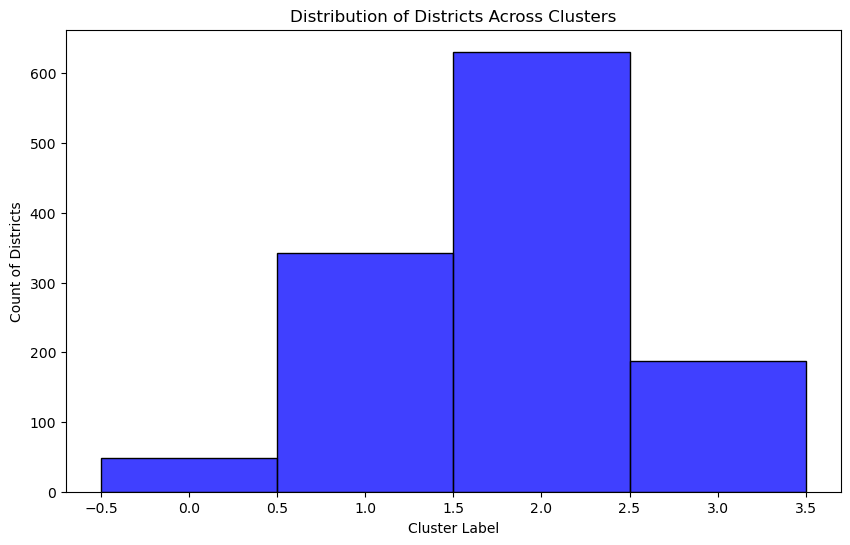

In [20]:
# ===========================
# Clustering for Student Data
# ===========================
print("Processing Student Membership Clustering...\n")
student_data, student_scaled = preprocess_data(df, student_features)

find_optimal_k(student_scaled)

optimal_k_students = 4
student_clusters, student_centroids = apply_kmeans(student_data, student_scaled, optimal_k_students)


Processing Staff Experience Clustering...



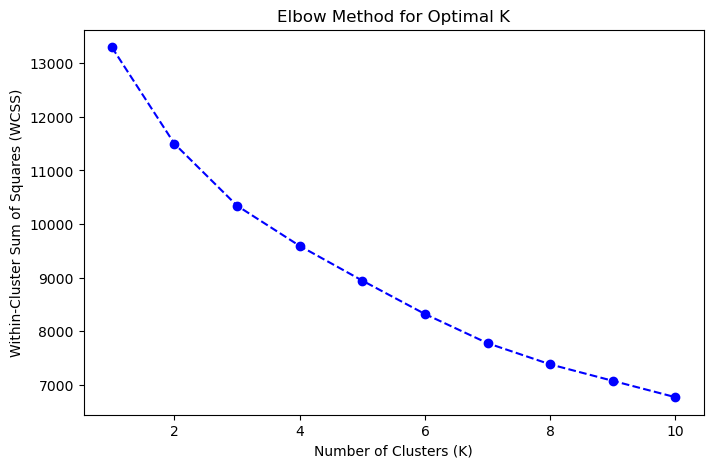

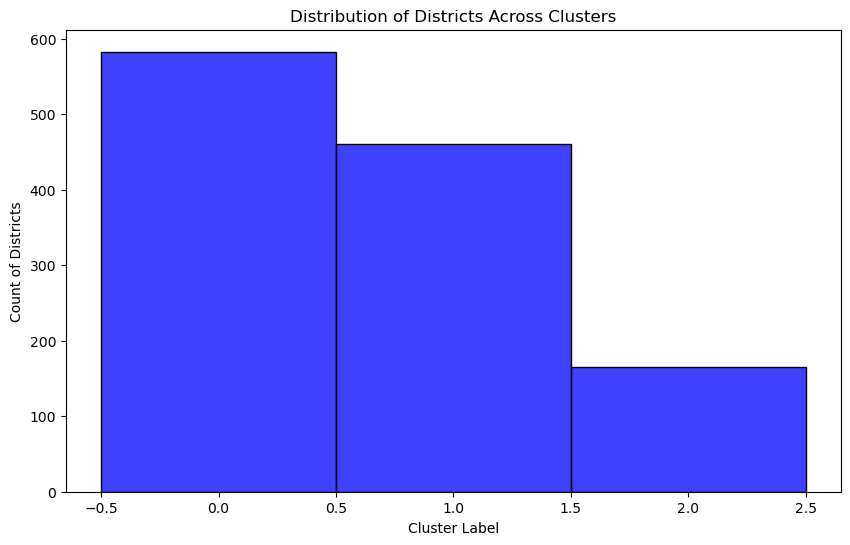

In [17]:
# ===========================
# Clustering for Staff Data
# ===========================
print("\nProcessing Staff Experience Clustering...\n")
staff_data, staff_scaled = preprocess_data(df, staff_features)

# Determine the best number of clusters for staff
find_optimal_k(staff_scaled)

# Choose the optimal K (modify after checking the elbow plot)
optimal_k_staff = 3
staff_clusters, staff_centroids = apply_kmeans(staff_data, staff_scaled, optimal_k_staff)


In [15]:
print("\nStudent Cluster Centroids:")
print(student_centroids)


Student Cluster Centroids:
   District 2023 Student Membership: White Percent  \
0                                        -0.213471   
1                                        -1.199910   
2                                         0.882064   

   District 2023 Student Membership: African American Percent  \
0                                           0.497365            
1                                          -0.127987            
2                                          -0.356558            

   District 2023 Student Membership: Hispanic Percent  \
0                                          -0.071006    
1                                           1.398038    
2                                          -0.750701    

   District 2023 Student Membership: American Indian Percent  \
0                                           0.016578           
1                                          -0.214262           
2                                           0.110116           

   Distr

In [21]:
print("\nStaff Cluster Centroids:")
print(staff_centroids)


Staff Cluster Centroids:
   District 2023 Staff: Teacher No Degree Full Time Equiv Percent  \
0                                          -0.168576                
1                                          -0.028445                
2                                           0.675960                

   District 2023 Staff: Teacher BA Degree Full Time Equiv Percent  \
0                                           0.563686                
1                                          -0.701092                
2                                          -0.040546                

   District 2023 Staff: Teacher MS Degree Full Time Equiv Percent  \
0                                          -0.504376                
1                                           0.753998                
2                                          -0.316871                

   District 2023 Staff: Teacher PH Degree Full Time Equiv Percent  \
0                                          -0.175485                
1    

In [29]:
# used this just to check correct names of columns
for col in df.columns:
    if col.startswith("District 2023 Student Membership:"):
        print(col)

District 2023 Student Membership: EE Count
District 2023 Student Membership: PK Count
District 2023 Student Membership: KG Count
District 2023 Student Membership: 01 Count
District 2023 Student Membership: 02 Count
District 2023 Student Membership: 03 Count
District 2023 Student Membership: 04 Count
District 2023 Student Membership: 05 Count
District 2023 Student Membership: 06 Count
District 2023 Student Membership: 07 Count
District 2023 Student Membership: 08 Count
District 2023 Student Membership: 09 Count
District 2023 Student Membership: 10 Count
District 2023 Student Membership: 11 Count
District 2023 Student Membership: 12 Count
District 2023 Student Membership: All Students Count
District 2023 Student Membership: Special Ed Count
District 2023 Student Membership: Bilingual/ESL Count
District 2023 Student Membership: Gifted & Talented Count
District 2023 Student Membership: EB/EL Count
District 2023 Student Membership: Econ Disadv Count
District 2023 Student Membership: Non-Edu